In [1]:
import torch
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

output_dir = Path("./flux_err_plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-15-3/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
_, test_image_full_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                                    0, 
                                                                    model_path, 
                                                                    lsst_root_dir, 
                                                                    device)

In [4]:
def filter_nan(data):
    output_data = []
    for sub_data in data:
        sub_data = np.array(sub_data)
        sub_data = sub_data[~np.isnan(sub_data)]
        output_data.append(sub_data.tolist())

    return output_data

matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_matching = list(matcher.match_catalogs(test_image_full_cat, bliss_full_cat)[0])
lsst_matching = list(matcher.match_catalogs(test_image_full_cat, lsst_full_cat)[0])

matching_inter = (bliss_matching[0].view(-1, 1) == lsst_matching[0].view(1, -1))
bliss_matching[0], bliss_matching[1] = bliss_matching[0][matching_inter.any(dim=-1)], bliss_matching[1][matching_inter.any(dim=-1)]
lsst_matching[0], lsst_matching[1] = lsst_matching[0][matching_inter.any(dim=0)], lsst_matching[1][matching_inter.any(dim=0)]

flux_bin_cutoffs = torch.tensor([200, 400, 600, 800, 1000])
n_flux_bins = flux_bin_cutoffs.shape[0] + 1
bands = ("u", "g", "r", "i", "z", "y")
bands_color_list = ("violet", "green", "red", "peru", "teal", "darkorange")

true_flux = test_image_full_cat.on_nmgy[0, bliss_matching[0], :]
bucketized_true_flux = torch.bucketize(true_flux, flux_bin_cutoffs)
bliss_flux = bliss_full_cat.on_nmgy[0, bliss_matching[1], :]
flux_err = (true_flux - bliss_flux) / true_flux
bliss_flux_err_flux_bin_dict = {i: [] for i in bands}

for band_idx, band_name in enumerate(bands):
    for flux_bin_idx in range(n_flux_bins):
        bliss_flux_err_flux_bin_dict[band_name].append(
            flux_err[bucketized_true_flux[:, band_idx] == flux_bin_idx, band_idx].tolist()
            )

true_flux = test_image_full_cat.on_nmgy[0, lsst_matching[0], :]
bucketized_true_flux = torch.bucketize(true_flux, flux_bin_cutoffs)
lsst_flux = lsst_full_cat.on_nmgy[0, lsst_matching[1], :]
flux_err = (true_flux - lsst_flux) / true_flux
lsst_flux_err_flux_bin_dict = {i: [] for i in bands}

for band_idx, band_name in enumerate(bands):
    for flux_bin_idx in range(n_flux_bins):
        lsst_flux_err_flux_bin_dict[band_name].append(
            flux_err[bucketized_true_flux[:, band_idx] == flux_bin_idx, band_idx].tolist()
            )

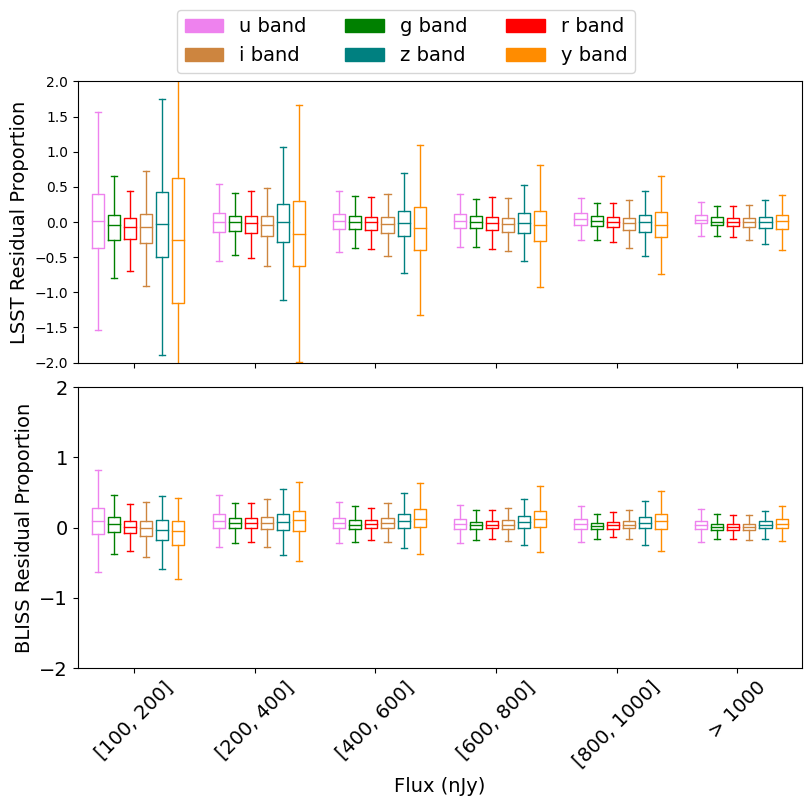

In [5]:
xlabels = (
    ["[100, " + str(flux_bin_cutoffs[0].item()) + "]"]
    + [f"[{flux_bin_cutoffs[i].item()}, {flux_bin_cutoffs[i + 1].item()}]" for i in range(len(flux_bin_cutoffs) - 1)]
    + ["> " + str(flux_bin_cutoffs[-1].item())]
)

def set_box_color(bp, color):
    plt.setp(bp["boxes"], color=color)
    plt.setp(bp["whiskers"], color=color)
    plt.setp(bp["caps"], color=color)
    plt.setp(bp["medians"], color=color)

fig, axes = plt.subplots(2, 1, figsize=NoteBookVariables.figsize, sharex="col", layout="constrained")

for i, (k, v) in enumerate(bliss_flux_err_flux_bin_dict.items()):
    bp = axes[1].boxplot(filter_nan(v), positions=np.array(list(range(len(v)))) * 3 + 0.4 * i, sym="", widths=0.3)
    set_box_color(bp, bands_color_list[i])

axes[1].set_ylabel("BLISS Residual Proportion", fontsize=NoteBookVariables.font_size)
axes[1].set_ylim(-2, 2)

for i, (k, v) in enumerate(lsst_flux_err_flux_bin_dict.items()):
    bp = axes[0].boxplot(filter_nan(v), positions=np.array(list(range(len(v)))) * 3 + 0.4 * i, sym="", widths=0.3)
    set_box_color(bp, bands_color_list[i])

axes[0].set_ylabel("LSST Residual Proportion", fontsize=NoteBookVariables.font_size)
axes[0].set_ylim(-2, 2)
axes[0].set_xticks(np.array(list(range(len(bands)))) * 3 + 0.9)
axes[1].set_xticklabels(xlabels, rotation=45)
axes[1].tick_params(labelsize=NoteBookVariables.font_size)
axes[0].set_xlim(left=-0.5)
axes[1].set_xlabel("Flux (nJy)", fontsize=NoteBookVariables.font_size)

legend_handles = [mpatches.Patch(color=bands_color_list[0], label="u band"),
                  mpatches.Patch(color=bands_color_list[3], label="i band"),
                  mpatches.Patch(color=bands_color_list[1], label="g band"),
                  mpatches.Patch(color=bands_color_list[4], label="z band"),
                  mpatches.Patch(color=bands_color_list[2], label="r band"),
                  mpatches.Patch(color=bands_color_list[5], label="y band")]
fig.legend(handles=legend_handles,
           loc="outside upper center", fancybox=True, shadow=False, ncol=3,
           fontsize=NoteBookVariables.font_size)
plt.grid(visible=False, axis="x")
# plt.tight_layout()
fig.savefig(output_dir / "flux_err.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()

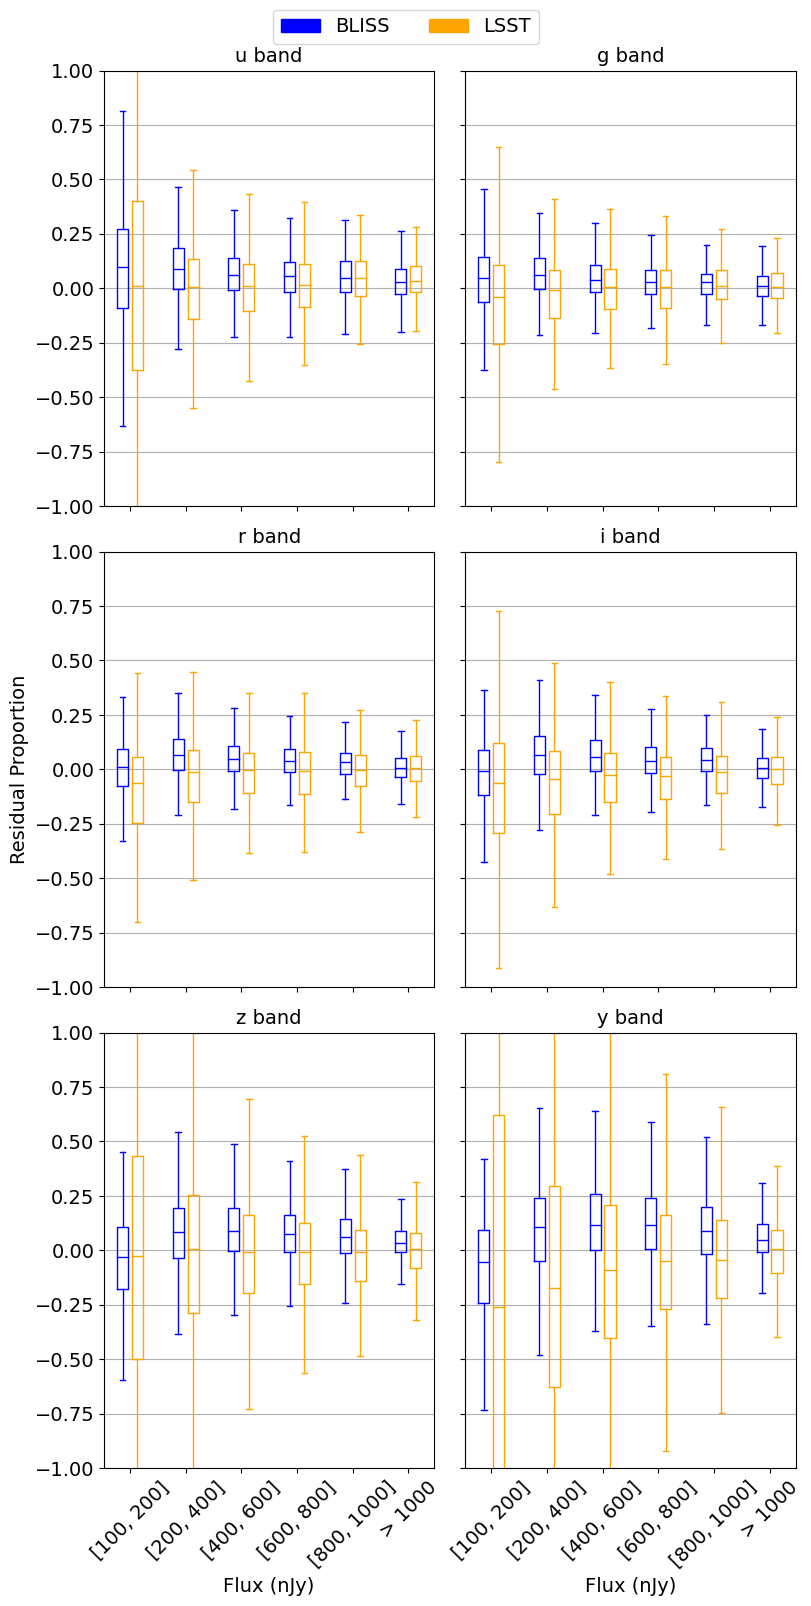

In [13]:
bliss_color = "blue"
lsst_color = "orange"

fig, axes = plt.subplots(3, 2, 
                         figsize=(NoteBookVariables.figsize[0], NoteBookVariables.figsize[1] * 2), 
                         sharex="col", 
                         sharey="row",
                         layout="constrained")

box_offset = np.array(list(range(len(bands)))) * 1.5
for i, band in enumerate(bands):
    col_index = i % 2
    row_index = i // 2
    ax = axes[row_index, col_index]
    bliss_flux_err = bliss_flux_err_flux_bin_dict[band]
    lsst_flux_err = lsst_flux_err_flux_bin_dict[band]
    bp = ax.boxplot(filter_nan(bliss_flux_err), positions=box_offset, sym="", widths=0.3)
    set_box_color(bp, bliss_color)
    bp = ax.boxplot(filter_nan(lsst_flux_err), positions=box_offset + 0.4, sym="", widths=0.3)
    set_box_color(bp, lsst_color)
    ax.set_title(f"{band} band", fontsize=NoteBookVariables.font_size)
    ax.set_ylim(-1.0, 1.0)
    ax.grid(visible=False, axis="x")
    ax.grid(visible=True, axis="y")
    
axes[1, 0].set_ylabel("Residual Proportion", fontsize=NoteBookVariables.font_size)
axes[2, 0].set_xticks(box_offset + 0.2)
axes[2, 0].set_xticklabels(xlabels, rotation=45)
axes[0, 0].tick_params(labelsize=NoteBookVariables.font_size)
axes[1, 0].tick_params(labelsize=NoteBookVariables.font_size)
axes[2, 0].tick_params(labelsize=NoteBookVariables.font_size)
axes[2, 0].set_xlim(left=-0.5)
axes[2, 0].set_xlabel("Flux (nJy)", fontsize=NoteBookVariables.font_size)
axes[2, 1].set_xticks(box_offset + 0.2)
axes[2, 1].set_xticklabels(xlabels, rotation=45)
axes[2, 1].tick_params(labelsize=NoteBookVariables.font_size)
axes[2, 1].set_xlim(left=-0.5)
axes[2, 1].set_xlabel("Flux (nJy)", fontsize=NoteBookVariables.font_size)

fig.legend(handles=[mpatches.Patch(color=bliss_color, label="BLISS"),
                    mpatches.Patch(color=lsst_color, label="LSST")],
           loc="outside upper center", fancybox=True, shadow=False, ncol=2,
           fontsize=NoteBookVariables.font_size)
fig.savefig(output_dir / "flux_err_separate.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig.show()